In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import pickle
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
ResNet50_MODEL=tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights="imagenet")

In [4]:
len(ResNet50_MODEL.layers)

175

In [5]:
ResNet50_MODEL.layers[15].name

'conv2_block1_0_bn'

In [6]:
for layer in ResNet50_MODEL.layers:
    layer.trainable=True

In [7]:
ResNet50_MODEL.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
batch_size = 64
l1_factor = 0.0001
l2_factor = 0.001
dropout = 0.5
learning_rate = 0.0001
target_size_image_shape = (224, 224)

In [9]:
model=tf.keras.models.Sequential([
                                  ResNet50_MODEL,
                                  tf.keras.layers.GlobalAveragePooling2D(),
                                  tf.keras.layers.Dropout(dropout, name='Dropout_Regularization1'),
                                  tf.keras.layers.Dense(16455, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
Dropout_Regularization1 (Dro (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 16455)             33716295  
Total params: 57,304,007
Trainable params: 57,250,887
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
train_data_dir = '../datasets/group2_set_224/set_224/train/'
valid_data_dir = '../datasets/group2_set_224/set_224/valid/'

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [12]:
#flow training images
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 144451 images belonging to 16455 classes.


In [13]:
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 65820 images belonging to 16455 classes.


### Save Labels in  Json file

In [14]:
indices_to_class_labels_dict = {value : key for key, value in train_generator.class_indices.items()}
print(len(indices_to_class_labels_dict))
print(indices_to_class_labels_dict)
with open("group2_indices_to_class_labels_dict.json", "wb") as pickle_file:
    pickle.dump(indices_to_class_labels_dict, pickle_file)

16455
{0: '10', 1: '100', 2: '100004', 3: '100005', 4: '100007', 5: '100009', 6: '100012', 7: '100017', 8: '100029', 9: '100050', 10: '100052', 11: '100059', 12: '10007', 13: '100088', 14: '100099', 15: '100107', 16: '100140', 17: '100154', 18: '100156', 19: '100180', 20: '100181', 21: '100183', 22: '100190', 23: '100204', 24: '100222', 25: '100227', 26: '100238', 27: '100245', 28: '10025', 29: '100255', 30: '100266', 31: '100284', 32: '100288', 33: '100304', 34: '100313', 35: '10032', 36: '100337', 37: '100345', 38: '100360', 39: '100376', 40: '100385', 41: '100404', 42: '100408', 43: '10041', 44: '10043', 45: '100438', 46: '100447', 47: '100468', 48: '100476', 49: '100477', 50: '100512', 51: '100539', 52: '100548', 53: '100560', 54: '100593', 55: '100606', 56: '10061', 57: '100639', 58: '100673', 59: '10069', 60: '100695', 61: '100697', 62: '100699', 63: '100712', 64: '100752', 65: '100755', 66: '100764', 67: '100768', 68: '100770', 69: '10078', 70: '100780', 71: '100783', 72: '10079

### Callbacks and Fitting Modeling

In [15]:
outputFolder = 'checkpoints_group2'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
checkpoint_filepath=outputFolder+"/model-{epoch:02d}-{val_acc:.2f}.hdf5"

In [16]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_acc', verbose=1, mode='max',
    save_best_only=True, save_weights_only=True,
    save_frequency='epoch')

In [ ]:
# history = model.fit_generator(
#     generator = train_generator,
#     steps_per_epoch = train_generator.n // batch_size,
#     validation_data = valid_generator,
#     validation_steps = valid_generator.n // batch_size,
#     callbacks=[checkpoint_callback],
#     epochs = 100,
#     workers = 4,
#     verbose=1
# )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
2257/2257 [==============================] - ETA: 0s - loss: 9.6350 - acc: 1.1769e-04
Epoch 00001: val_acc improved from -inf to 0.00135, saving model to checkpoints_group2/model-01-0.00.hdf5
2257/2257 [==============================] - 767s 340ms/step - loss: 9.6350 - acc: 1.1769e-04 - val_loss: 9.1242 - val_acc: 0.0014
Epoch 2/100
2257/2257 [==============================] - ETA: 0s - loss: 8.2966 - acc: 0.0120
Epoch 00002: val_acc improved from 0.00135 to 0.06354, saving model to checkpoints_group2/model-02-0.06.hdf5
2257/2257 [==============================] - 771s 341ms/step - loss: 8.2966 - acc: 0.0120 - val_loss: 7.1449 - val_acc: 0.0635
Epoch 3/100
2257/2257 [==============================] - ETA: 0s - loss: 6.0454 - acc: 0.1217
Epoch 00003: val_acc improved from 0.06354 to 0.17985, saving model to checkpoints_group2/model-03-0.18.hdf5
2257/2257 [==============================] - 769s 341ms/

Epoch 27/100
2257/2257 [==============================] - ETA: 0s - loss: 0.2642 - acc: 0.9276
Epoch 00027: val_acc did not improve from 0.43243
2257/2257 [==============================] - 771s 341ms/step - loss: 0.2642 - acc: 0.9276 - val_loss: 6.0859 - val_acc: 0.4267
Epoch 28/100
2257/2257 [==============================] - ETA: 0s - loss: 0.2515 - acc: 0.9312
Epoch 00028: val_acc did not improve from 0.43243
2257/2257 [==============================] - 771s 342ms/step - loss: 0.2515 - acc: 0.9312 - val_loss: 7.0719 - val_acc: 0.4147
Epoch 29/100
2257/2257 [==============================] - ETA: 0s - loss: 0.2360 - acc: 0.9364
Epoch 00029: val_acc improved from 0.43243 to 0.43461, saving model to checkpoints_group2/model-29-0.43.hdf5
2257/2257 [==============================] - 772s 342ms/step - loss: 0.2360 - acc: 0.9364 - val_loss: 6.5243 - val_acc: 0.4346
Epoch 30/100
2257/2257 [==============================] - ETA: 0s - loss: 0.2197 - acc: 0.9399
Epoch 00030: val_acc did not i

In [17]:
model.load_weights("checkpoints_group2/model-31-0.44.hdf5")

In [18]:
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // batch_size,
    callbacks=[checkpoint_callback],
    epochs = 67,
    workers = 4,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/67
2257/2257 [==============================] - ETA: 0s - loss: 0.2279 - acc: 0.9372
Epoch 00001: val_acc improved from -inf to 0.40353, saving model to checkpoints_group2/model-01-0.40.hdf5
2257/2257 [==============================] - 767s 340ms/step - loss: 0.2279 - acc: 0.9372 - val_loss: 7.3301 - val_acc: 0.4035
Epoch 2/67
2257/2257 [==============================] - ETA: 0s - loss: 0.1935 - acc: 0.9464
Epoch 00002: val_acc improved from 0.40353 to 0.41982, saving model to checkpoints_group2/model-02-0.42.hdf5
2257/2257 [==============================] - 773s 342ms/step - loss: 0.1935 - acc: 0.9464 - val_loss: 7.0338 - val_acc: 0.4198
Epoch 3/67
2257/2257 [==============================] - ETA: 0s - loss: 0.1846 - acc: 0.9489
Epoch 00003: val_acc did not improve from 0.41982
2257/2257 [==============================] - 769s 341ms/step - loss: 0.1846 - acc: 0.9489 - val_loss: 7.1968 - val_acc: 0.4187

2257/2257 [==============================] - ETA: 0s - loss: 0.0777 - acc: 0.9781
Epoch 00029: val_acc did not improve from 0.44896
2257/2257 [==============================] - 766s 340ms/step - loss: 0.0777 - acc: 0.9781 - val_loss: 7.8008 - val_acc: 0.4312
Epoch 30/67
2257/2257 [==============================] - ETA: 0s - loss: 0.0799 - acc: 0.9774
Epoch 00030: val_acc did not improve from 0.44896
2257/2257 [==============================] - 766s 339ms/step - loss: 0.0799 - acc: 0.9774 - val_loss: 7.5189 - val_acc: 0.4321
Epoch 31/67
2257/2257 [==============================] - ETA: 0s - loss: 0.0742 - acc: 0.9793
Epoch 00031: val_acc did not improve from 0.44896
2257/2257 [==============================] - 766s 339ms/step - loss: 0.0742 - acc: 0.9793 - val_loss: 7.9650 - val_acc: 0.4299
Epoch 32/67
2257/2257 [==============================] - ETA: 0s - loss: 0.0760 - acc: 0.9784
Epoch 00032: val_acc did not improve from 0.44896
2257/2257 [==============================] - 766s 339ms

2257/2257 [==============================] - ETA: 0s - loss: 0.0466 - acc: 0.9873
Epoch 00059: val_acc did not improve from 0.45988
2257/2257 [==============================] - 768s 340ms/step - loss: 0.0466 - acc: 0.9873 - val_loss: 8.0757 - val_acc: 0.4299
Epoch 60/67
2257/2257 [==============================] - ETA: 0s - loss: 0.0457 - acc: 0.9873
Epoch 00060: val_acc did not improve from 0.45988
2257/2257 [==============================] - 769s 341ms/step - loss: 0.0457 - acc: 0.9873 - val_loss: 8.7128 - val_acc: 0.4175
Epoch 61/67
2257/2257 [==============================] - ETA: 0s - loss: 0.0466 - acc: 0.9865
Epoch 00061: val_acc did not improve from 0.45988
2257/2257 [==============================] - 768s 340ms/step - loss: 0.0466 - acc: 0.9865 - val_loss: 8.5149 - val_acc: 0.4367
Epoch 62/67
2257/2257 [==============================] - ETA: 0s - loss: 0.0450 - acc: 0.9874
Epoch 00062: val_acc did not improve from 0.45988
2257/2257 [==============================] - 768s 340ms

<Figure size 432x288 with 0 Axes>

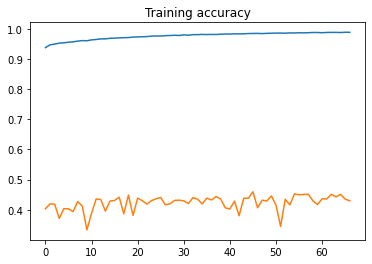

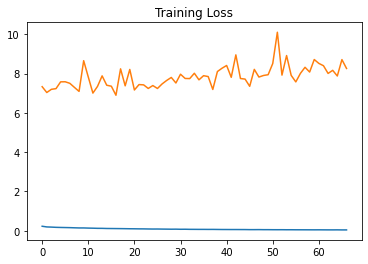

<Figure size 432x288 with 0 Axes>

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training Loss')
plt.figure()

In [ ]:
gsedrfgdffg